In [1]:
import numpy as np
import h5py
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-09-14 12:37:11.319275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 12:37:11.331619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 12:37:11.701900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 12:37:13.063166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [4]:
class Hdf5DataGenerator:

    def __call__(self, filename, batchsize, normalise=True):
        
        # When using with tensorflow datasets, string args are passed as bytes.
        # Convert them back
        if isinstance(filename, bytes):
            filename = filename.decode()

        with h5py.File(filename, "r") as fin:

            waveforms = fin.get('waveforms')
            event_types = fin.get('type')
            p_start = fin.get('p_start')
            s_start = fin.get('s_start')

            waveform_length = waveforms[0].shape[0]
            istart = 0
            istop = batchsize
            exhausted = False

            pick_width = 100
            half_pick_width = pick_width // 2
            pick = scipy.signal.windows.gaussian(pick_width, 12)

            while not exhausted:

                data = waveforms[istart:istop]
                targets = []

                if normalise:
                    max_vals = np.max(np.abs(data), axis=1, keepdims=True)
                    data /= (max_vals + 1e-8)

                # Create the target class waveforms 
                for i in range(batchsize):

                    p_true = np.zeros(shape=(waveform_length))
                    s_true = np.zeros(shape=(waveform_length))
                    n_true = np.ones(shape=(waveform_length))

                    p_pos = p_start[i]
                    s_pos = s_start[i]
                    
                    # Ensure there is a valid pick                    
                    if p_pos > 0 and s_pos > 0:
                    
                        # Insert pick 
                        p_true[p_pos - half_pick_width : p_pos + half_pick_width] = pick
                        s_true[s_pos - half_pick_width : s_pos + half_pick_width] = pick
                        
                        n_true -= p_true
                        n_true -= s_true

                    targets.append(
                        np.dstack([p_true, s_true, n_true])
                    )

                yield (data, np.vstack(targets))

                istart += batchsize
                istop += batchsize

                if istop > len(waveforms):
                    exhausted = True

batch_data.shape: (1, 6000, 1)
batch_targets.shape: (1, 6000, 3)


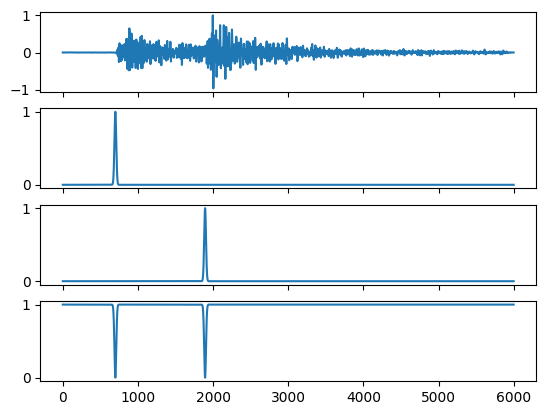

In [5]:
gen = Hdf5DataGenerator()


for batch in gen('events_phases_Zonly_TRAIN.h5', 1):

    batch_data = batch[0]
    batch_targets = batch[1]
    
    print('batch_data.shape:', batch_data.shape)
    print('batch_targets.shape:', batch_targets.shape)

    for i in range(batch_data.shape[0]):

        data = batch_data[i]
        targets = batch_targets[i]
        
        _, ax = plt.subplots(4, 1, sharex=True)
        xvals = np.arange(data.shape[0])
    
        ax[0].plot(xvals, data[:, 0])
        ax[1].plot(xvals, targets[:, 0])
        ax[2].plot(xvals, targets[:, 1])
        ax[3].plot(xvals, targets[:, 2])

    
        break
    break

In [10]:
# make the tf dataset

filename_train = 'events_phases_Zonly_TRAIN.h5'
batch_size = 128

train_dataset = tf.data.Dataset.from_generator(
    Hdf5DataGenerator(),
    output_signature=(
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data'),
        tf.TensorSpec(shape=(None, 6000, 3), dtype=tf.float32, name='targets')
    ), 
    args=(filename_train, batch_size)
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [11]:
# test it

for data, target in train_dataset.take(1):

    print('data.shape:', data.shape)
    print('target.shape:', target.shape)

data.shape: (128, 6000, 1)
target.shape: (128, 6000, 3)


2025-09-14 12:40:29.579357: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1: simple down and up

2: U-net

In [26]:
def make_model():
    
    inputs = keras.Input(shape=(6000, 1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv1D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 64, 64]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling1D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv1D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [64, 64, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling1D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling1D(2)(previous_block_activation)
        residual = keras.layers.Conv1D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv1D(3, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)

    return model

In [27]:
model = make_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 6000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 3000, 32)  │        128 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 3000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 3000, 32)  │          0 │ activation_30[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 3000, 64)  │      6,208 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 3000, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 3000, 64)  │     12,352 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 1500, 64)  │      2,112 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 1500, 64)  │          0 │ max_pooling1d_8[… │
│                     │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 1500, 64)  │          0 │ add_10[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_36[0][0] 

 Total params: 180,227 (704.01 KB)

 Trainable params: 178,499 (697.26 KB)

 Non-trainable params: 1,728 (6.75 KB)

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy"
)

In [29]:
epochs = 1
model.fit(
    train_dataset,
    epochs=epochs,
    verbose=1,
)

2025-09-14 12:45:50.361709: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


    454/Unknown 806s 2s/step - loss: 0.4354

KeyboardInterrupt: 